# DASC 512 - Week 8 - Regression Examples

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.graphics.api as smg
import statsmodels.formula.api as smf

sns.set_style('darkgrid')

In [36]:
def linearity_test(model, y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    It uses Locally Weighted Scatterplot Smoothing (LOWESS) to fit a model. 
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    pred = model.fittedvalues
    influence = model.get_influence()
    resid_std = influence.resid_studentized_internal
    
    fig, ax = plt.subplots(1,2, figsize=(7.5,3.5))
    
    sns.regplot(x=pred, y=y, lowess=True, ax=ax[0], line_kws={'color':'darkorchid'})
    # I've added the ideal line (y=yhat) for comparison
    sns.lineplot(x=[min(pred), max(pred)], y=[min(pred), max(pred)], 
                 ax=ax[0], color='red', ls=':')
    ax[0].set_title('Observed vs. Predicted Values')
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('Observed')
    
    sns.regplot(x=pred, y=resid_std, lowess=True, ax=ax[1], line_kws={'color':'darkorchid'})
    # I've added the ideal line (y=0) for comparison
    sns.lineplot(x=[min(pred), max(pred)], y=[0,0], ax=ax[1], color='red', ls=':')
    ax[1].set_title('Residuals vs. Predicted Values')
    ax[1].set_xlabel('Predicted')
    ax[1].set_ylabel('Standardized Residual')
    
    return fig, ax

## Species Diversity in the Galapagos

In [37]:
gala = pd.read_csv('gala.csv')

In [38]:
gala.head()

,id,island,species,area,elevation,nearest,scruz,adjacent
0,1,Baltra,58,25.09,346,0.6,0.6,1.84
1,2,Bartolome,31,1.24,109,0.6,26.3,572.33
2,3,Caldwell,3,0.21,114,2.8,58.7,0.78
3,4,Champion,25,0.10,46,1.9,47.4,0.18
4,5,Coamano,2,0.05,77,1.9,1.9,903.82


In [39]:
gala['island'].value_counts()

Baltra          1
Bartolome       1
Tortuga         1
Seymour         1
SantaMaria      1
SantaFe         1
SantaCruz       1
SanSalvador     1
SanCristobal    1
Rabida          1
Las.Plazas      1
Pinzon          1
Pinta           1
Onslow          1
Marchena        1
Isabela         1
Genovesa        1
Gardner2        1
Gardner1        1
Fernandina      1
Espanola        1
Enderby         1
Eden            1
Darwin          1
Daphne.Minor    1
Daphne.Major    1
Coamano         1
Champion        1
Caldwell        1
Wolf            1
Name: island, dtype: int64

We see that island won't be helpful, because it is a unique identifier for each of the islands in the Galapagos Islands. So is ID so let's drop it.

In [40]:
gala.drop('id', axis=1, inplace=True)

In [41]:
gala.describe()

,species,area,elevation,nearest,scruz,adjacent
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,85.233333,261.708667,368.033333,10.060000,56.976667,261.098333
std,114.633053,864.110519,421.604937,14.274636,68.032334,864.518967
min,2.000000,0.010000,25.000000,0.200000,0.000000,0.030000
25%,13.000000,0.257500,97.750000,0.800000,11.025000,0.520000
50%,42.000000,2.590000,192.000000,3.050000,46.650000,2.590000
75%,96.000000,59.237500,435.250000,10.025000,81.075000,59.237500
max,444.000000,4669.320000,1707.000000,47.400000,290.200000,4669.320000


Species is our desired response variable. Area is the island area in $km^2$, elevation is the highest elevation in km, nearest is the distance to the nearest other island, adjacent is the area of that nearest island, and scruz is the distance from Santa Cruz, the main island.

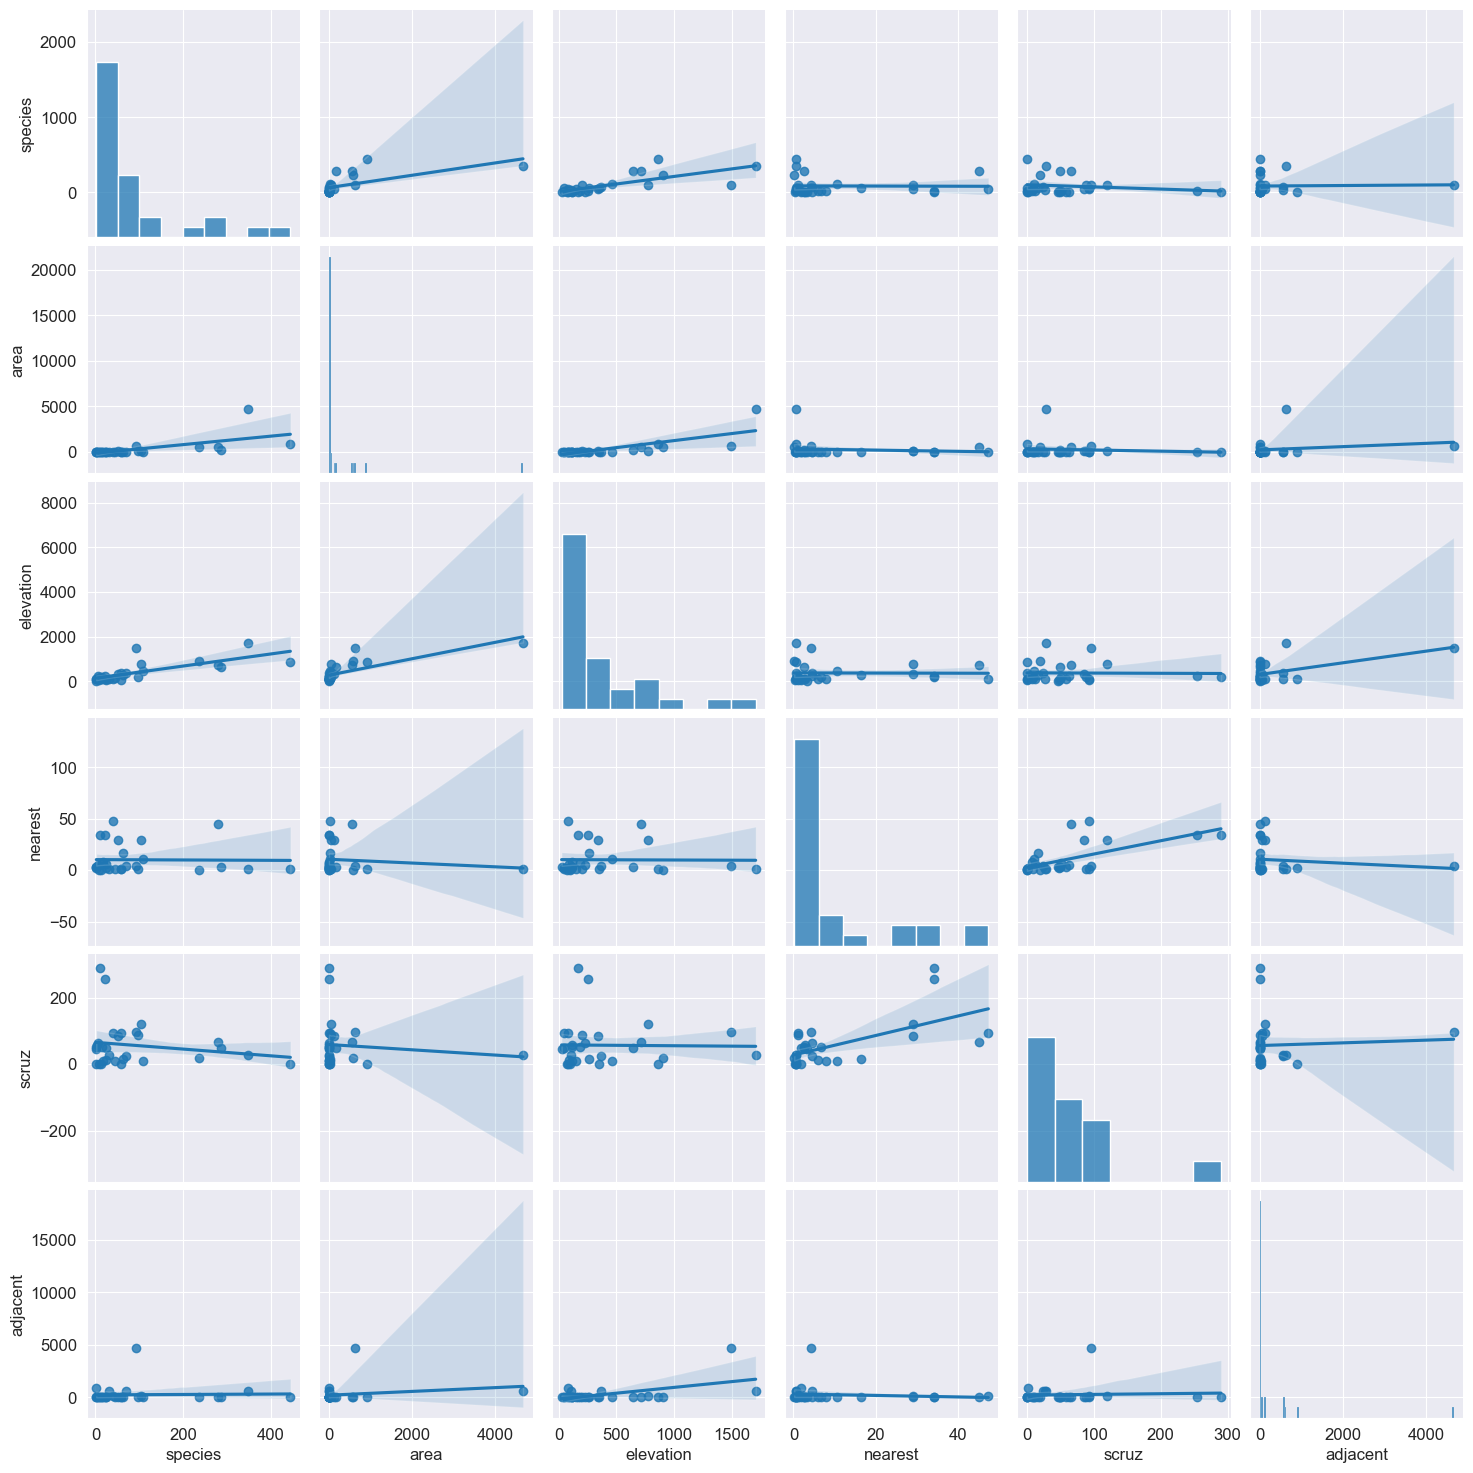

In [42]:
sns.pairplot(gala[['species','area','elevation','nearest','scruz','adjacent']],
            kind='reg')
plt.show()

It's hard to see much information in this pairplot, largely because the species variable is so highly skewed. We'll deal with that in a bit.

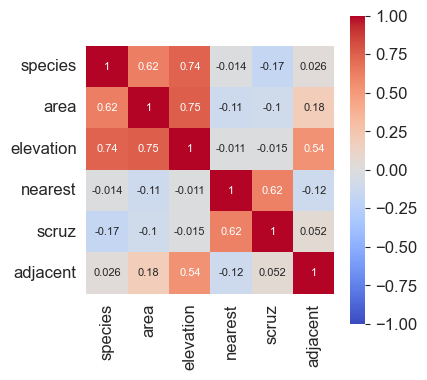

In [46]:
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(gala.corr(),vmin=-1,vmax=1,cmap='coolwarm', square=True,
           annot=True, ax=ax, annot_kws={'fontsize':8})
plt.show()

In [44]:
gala.corr()

,species,area,elevation,nearest,scruz,adjacent
species,1.000000,0.617843,0.738487,-0.014094,-0.171142,0.026166
area,0.617843,1.000000,0.753735,-0.111103,-0.100785,0.180038
elevation,0.738487,0.753735,1.000000,-0.011077,-0.015438,0.536458
nearest,-0.014094,-0.111103,-0.011077,1.000000,0.615410,-0.116248
scruz,-0.171142,-0.100785,-0.015438,0.615410,1.000000,0.051661
adjacent,0.026166,0.180038,0.536458,-0.116248,0.051661,1.000000


It looks like species is correlated most strongly with area and elevation, but let's start with the full first-order model and look at the residuals.

In [47]:
formula = 'species ~ area + elevation + nearest + scruz + adjacent'
gmodel = smf.ols(formula,gala).fit()
gmodel.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.717   
Dependent Variable: species          AIC:                337.0700
Date:               2022-11-21 11:49 BIC:                345.4772
No. Observations:   30               Log-Likelihood:     -162.54 
Df Model:           5                F-statistic:        15.70   
Df Residuals:       24               Prob (F-statistic): 6.84e-07
R-squared:          0.766            Scale:              3718.0  
------------------------------------------------------------------
              Coef.   Std.Err.     t     P>|t|    [0.025    0.975]
------------------------------------------------------------------
Intercept     7.0682   19.1542   0.3690  0.7154  -32.4641  46.6005
area         -0.0239    0.0224  -1.0676  0.2963   -0.0702   0.0223
elevation     0.3195    0.0537   5.9532  0.0000    0.2087   0.4302
nearest       0.0091    1.0541   0.0087  0.9932   -2.1665   2.1848
scruz        -0.2405    0.2154  -1.1166  0.2752   -0.6851   0.2040
adjacent     -0.0748    0.0177  -4.2262  0.0003   -0.1113  -0.0383
-----------------------------------------------------------------
Omnibus:              12.683       Durbin-Watson:          2.476 
Prob(Omnibus):        0.002        Jarque-Bera (JB):       13.498
Skew:                 1.136        Prob(JB):               0.001 
Kurtosis:             5.374        Condition No.:          1900  
=================================================================
* The condition number is large (2e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

Nearest looks like the first term we'd want to drop. Before we mess with the model, let's look at the residuals. Typically if you have issues with residuals in the full model, it won't get better as you remove terms.

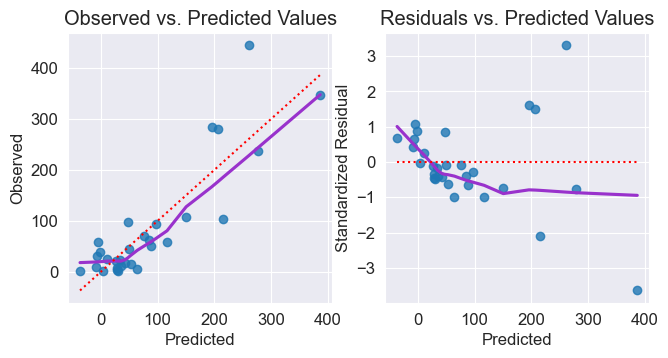

In [50]:
fig, ax = linearity_test(gmodel, gala['species'])
plt.show()

In [51]:
resid = gmodel.resid
pred = gmodel.fittedvalues

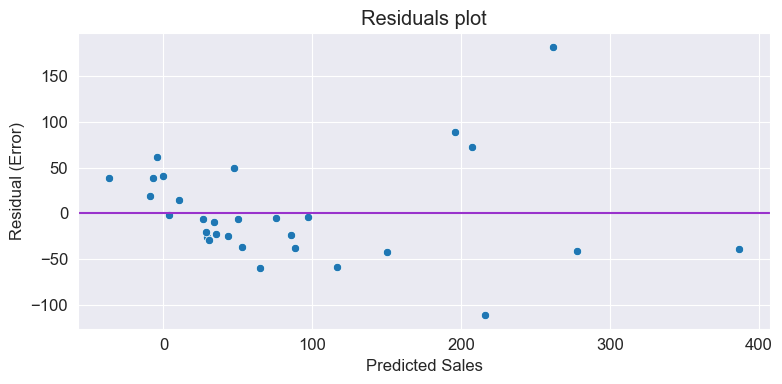

In [54]:
fig, ax = plt.subplots(figsize=(8,4))
sns.scatterplot(x=pred, y=resid, ax=ax)
ax.set_title('Residuals plot')
ax.set_ylabel('Residual (Error)')
ax.set_xlabel('Predicted Sales')
fig.tight_layout()
plt.axhline(y=0, color='darkorchid')
plt.show()

Yikes. There's a pretty clear pattern in variance as well as the mean.

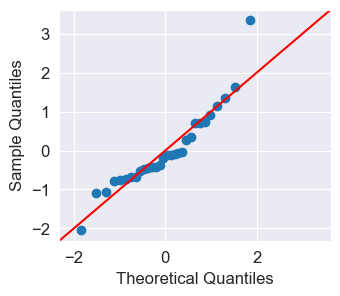

In [57]:
fig, ax = plt.subplots(figsize=(3.5,3))
smg.qqplot(resid,line='45',fit=True, ax=ax)
plt.show()

Normality isn't too bad except for one point, but we need to do something about that mean and variance. Let's start with a Box-Cox transformation.

In [59]:
gala['species_bc'], lamb, ci = stats.boxcox(gala['species'], alpha=0.1)

In [60]:
lamb

0.08809980398939382

In [61]:
ci

(-0.10405870216714665, 0.2833314297933692)

When $\lambda=0$, the Box-Cox transform uses $\ln{x}$. Otherwise it uses $\frac{x^\lambda-1}{\lambda}$. So we're pretty close the the natural log, and I'd probably use that instead of the Box-Cox transformation, but to demonstrate the Box-Cox we'll play with both.

In [62]:
gala['species_ln'] = gala['species'].apply(np.log)

This should make species look more normal. Let's do some comparisons by QQ-plots.

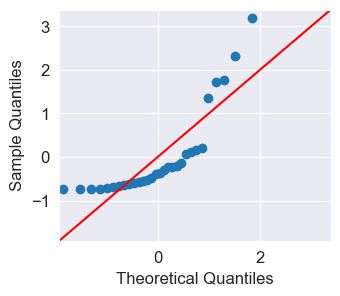

In [63]:
fig, ax = plt.subplots(figsize=(3.5,3))
smg.qqplot(gala['species'], fit=True, line='45', ax=ax)
plt.show()

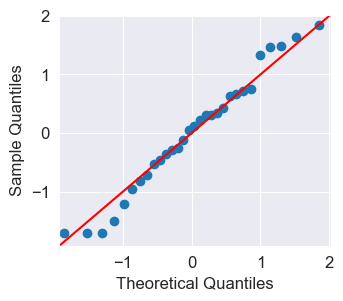

In [64]:
fig, ax = plt.subplots(figsize=(3.5,3))
smg.qqplot(gala['species_bc'],fit=True,line='45', ax=ax)
plt.show()

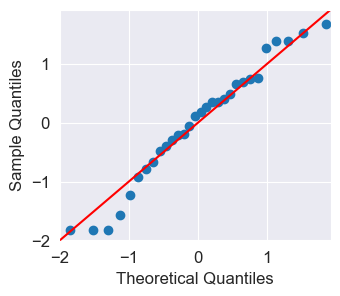

In [65]:
# Logarithmic model is almost identically normal
fig, ax = plt.subplots(figsize=(3.5,3))
smg.qqplot(gala['species_ln'],fit=True,line='45', ax=ax)
plt.show()

By either transformation this is looking waaaay better. Let's build a model now based on the Box-Cox transformed data.

In [66]:
formula = 'species_bc ~ area + elevation + nearest + scruz + adjacent'
gmodel = smf.ols(formula,gala).fit()
gmodel.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.598   
Dependent Variable: species_bc       AIC:                107.8899
Date:               2022-11-21 11:55 BIC:                116.2971
No. Observations:   30               Log-Likelihood:     -47.945 
Df Model:           5                F-statistic:        9.627   
Df Residuals:       24               Prob (F-statistic): 3.85e-05
R-squared:          0.667            Scale:              1.7889  
------------------------------------------------------------------
               Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
------------------------------------------------------------------
Intercept      2.6103    0.4201   6.2127  0.0000   1.7431   3.4774
area          -0.0010    0.0005  -1.9781  0.0595  -0.0020   0.0000
elevation      0.0062    0.0012   5.2927  0.0000   0.0038   0.0087
nearest        0.0203    0.0231   0.8791  0.3881  -0.0274   0.0680
scruz         -0.0054    0.0047  -1.1413  0.2650  -0.0151   0.0044
adjacent      -0.0011    0.0004  -2.9128  0.0076  -0.0019  -0.0003
-----------------------------------------------------------------
Omnibus:               0.045        Durbin-Watson:          2.638
Prob(Omnibus):         0.978        Jarque-Bera (JB):       0.183
Skew:                  -0.081       Prob(JB):               0.912
Kurtosis:              2.653        Condition No.:          1900 
=================================================================
* The condition number is large (2e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

I'd remove nearest first. Let's do that.

In [67]:
formula = 'species_bc ~ area + elevation + scruz + adjacent'
gmodel = smf.ols(formula,gala).fit()
gmodel.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.602   
Dependent Variable: species_bc       AIC:                106.8407
Date:               2022-11-21 11:57 BIC:                113.8466
No. Observations:   30               Log-Likelihood:     -48.420 
Df Model:           4                F-statistic:        11.95   
Df Residuals:       25               Prob (F-statistic): 1.45e-05
R-squared:          0.657            Scale:              1.7726  
------------------------------------------------------------------
               Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
------------------------------------------------------------------
Intercept      2.6262    0.4178   6.2850  0.0000   1.7656   3.4867
area          -0.0011    0.0005  -2.2132  0.0362  -0.0020  -0.0001
elevation      0.0065    0.0011   5.6796  0.0000   0.0041   0.0088
scruz         -0.0028    0.0037  -0.7615  0.4535  -0.0104   0.0048
adjacent      -0.0012    0.0004  -3.3131  0.0028  -0.0020  -0.0005
-----------------------------------------------------------------
Omnibus:               0.676        Durbin-Watson:          2.720
Prob(Omnibus):         0.713        Jarque-Bera (JB):       0.758
Skew:                  -0.281       Prob(JB):               0.685
Kurtosis:              2.461        Condition No.:          1899 
=================================================================
* The condition number is large (2e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

That improved the model. Let's go ahead and remove scruz too.

In [68]:
formula = 'species_bc ~ area + elevation + adjacent'
gmodel = smf.ols(formula,gala).fit()
gmodel.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.608   
Dependent Variable: species_bc       AIC:                105.5285
Date:               2022-11-21 11:57 BIC:                111.1333
No. Observations:   30               Log-Likelihood:     -48.764 
Df Model:           3                F-statistic:        16.00   
Df Residuals:       26               Prob (F-statistic): 4.27e-06
R-squared:          0.649            Scale:              1.7440  
------------------------------------------------------------------
               Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
------------------------------------------------------------------
Intercept      2.4768    0.3660   6.7679  0.0000   1.7246   3.2291
area          -0.0010    0.0005  -2.1562  0.0405  -0.0020  -0.0000
elevation      0.0064    0.0011   5.6895  0.0000   0.0041   0.0087
adjacent      -0.0012    0.0004  -3.3544  0.0025  -0.0020  -0.0005
-----------------------------------------------------------------
Omnibus:               1.294        Durbin-Watson:          2.639
Prob(Omnibus):         0.524        Jarque-Bera (JB):       1.144
Skew:                  -0.307       Prob(JB):               0.564
Kurtosis:              2.267        Condition No.:          1676 
=================================================================
* The condition number is large (2e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

Nice. Let's look at the residuals now.

In [69]:
resid = gmodel.resid
pred = gmodel.fittedvalues

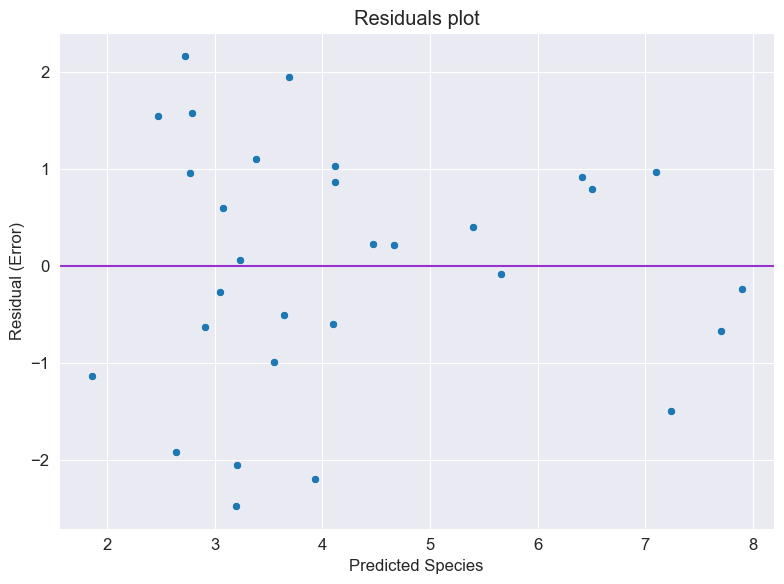

In [73]:
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(x=pred, y=resid, ax=ax)
ax.set_title('Residuals plot')
ax.set_ylabel('Residual (Error)')
ax.set_xlabel('Predicted Species')
fig.tight_layout()
plt.axhline(y=0, color='darkorchid')
plt.show()

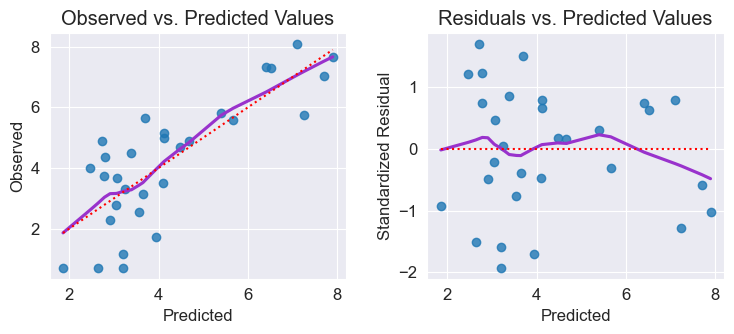

In [77]:
fig, ax = linearity_test(gmodel, gala['species_bc'])
fig.tight_layout()
plt.show()

That looks better. Not perfect, but much better. The mean appears to now be constant at 0. The variance is roughly equal - the appearance of a pattern can be explained by the lack of data for high predicted species.

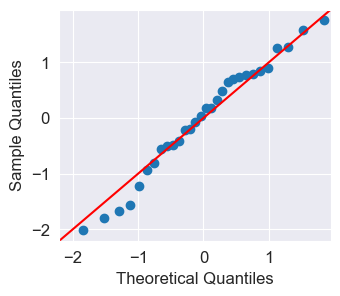

In [78]:
fig, ax = plt.subplots(figsize=(3.5,3))
smg.qqplot(resid, fit=True, line='45', ax=ax)
plt.show()

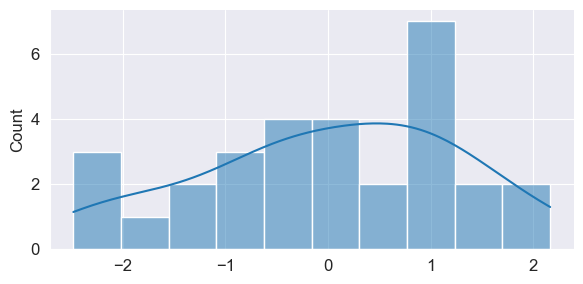

In [87]:
sns.displot(resid, kde=True, aspect=2, height=3, bins=10)
plt.show()

I'd like to visualize the model, but we have a problem. How do we get transform back to normal scale?

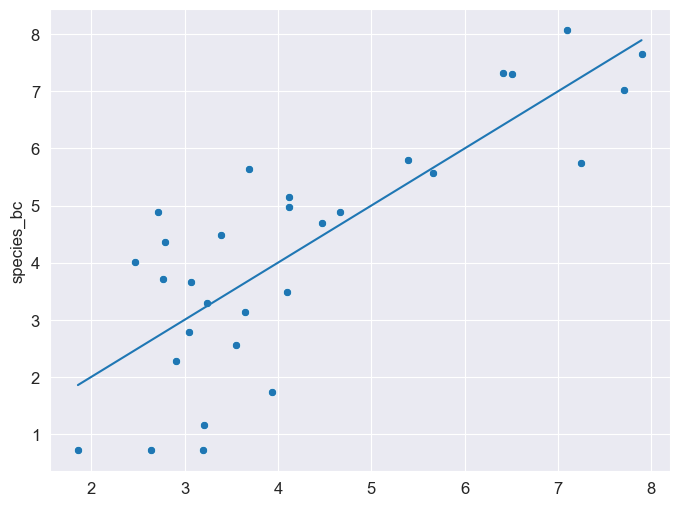

In [91]:
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(x=pred, y=gala['species_bc'])
sns.lineplot(x=pred,y=pred)
plt.show()

In [92]:
gala['species']

0      58
1      31
2       3
3      25
4       2
5      18
6      24
7      10
8       8
9       2
10     97
11     93
12     58
13      5
14     40
15    347
16     51
17      2
18    104
19    108
20     12
21     70
22    280
23    237
24    444
25     62
26    285
27     44
28     16
29     21
Name: species, dtype: int64

In [93]:
#One way - using a built-in function
from scipy.special import inv_boxcox
spec = inv_boxcox(gala['species_bc'],lamb)
spec

0      58.0
1      31.0
2       3.0
3      25.0
4       2.0
5      18.0
6      24.0
7      10.0
8       8.0
9       2.0
10     97.0
11     93.0
12     58.0
13      5.0
14     40.0
15    347.0
16     51.0
17      2.0
18    104.0
19    108.0
20     12.0
21     70.0
22    280.0
23    237.0
24    444.0
25     62.0
26    285.0
27     44.0
28     16.0
29     21.0
Name: species_bc, dtype: float64

In [94]:
# Alternatively and possibly easier if you can remember it
spec = gala['species_bc'].apply(lambda xx: (lamb * xx + 1)**(1/lamb))
spec

0      58.0
1      31.0
2       3.0
3      25.0
4       2.0
5      18.0
6      24.0
7      10.0
8       8.0
9       2.0
10     97.0
11     93.0
12     58.0
13      5.0
14     40.0
15    347.0
16     51.0
17      2.0
18    104.0
19    108.0
20     12.0
21     70.0
22    280.0
23    237.0
24    444.0
25     62.0
26    285.0
27     44.0
28     16.0
29     21.0
Name: species_bc, dtype: float64

In [96]:
# Inverse of np.log is np.exp
gala['species_ln'].apply(np.exp)

0      58.0
1      31.0
2       3.0
3      25.0
4       2.0
5      18.0
6      24.0
7      10.0
8       8.0
9       2.0
10     97.0
11     93.0
12     58.0
13      5.0
14     40.0
15    347.0
16     51.0
17      2.0
18    104.0
19    108.0
20     12.0
21     70.0
22    280.0
23    237.0
24    444.0
25     62.0
26    285.0
27     44.0
28     16.0
29     21.0
Name: species_ln, dtype: float64

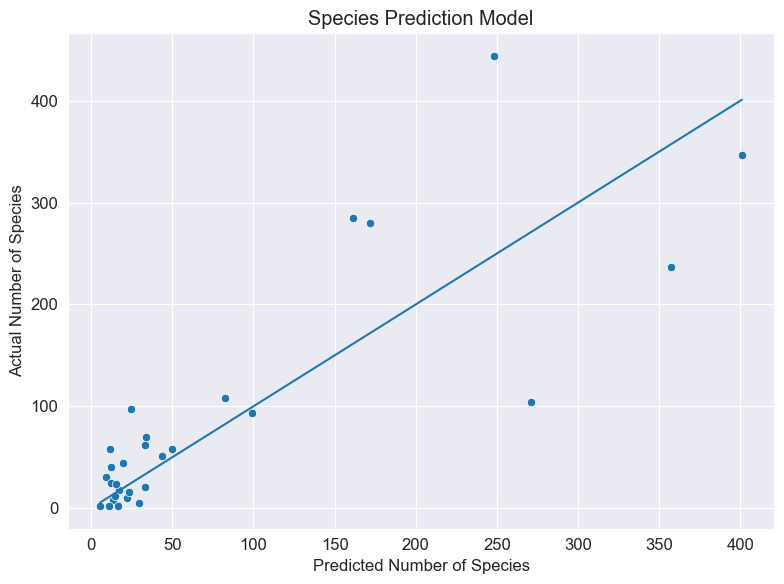

In [100]:
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(x=inv_boxcox(pred,lamb), y=gala['species'])
sns.lineplot(x=inv_boxcox(pred,lamb),y=inv_boxcox(pred,lamb))
ax.set_ylabel('Actual Number of Species')
ax.set_xlabel('Predicted Number of Species')
ax.set_title('Species Prediction Model')
fig.tight_layout()
plt.show()